In [1]:
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer

Mounted at /content/gdrive


Declaramos los siguientes paths que contendran la direccion de nuestro drive en el cual se encuentran los dataframes (tener en cuenta a la hora de probar).

In [2]:
path1 = "/content/gdrive/MyDrive/data_science/challengeK_housePrediction/sample_submission.csv"
path2 = "/content/gdrive/MyDrive/data_science/challengeK_housePrediction/test.csv"
path3 = "/content/gdrive/MyDrive/data_science/challengeK_housePrediction/train.csv"

In [3]:
df_train = pd.read_csv(path3)
df_test = pd.read_csv(path2)
df_sample = pd.read_csv(path1) 

### Primera aproximacion a los datos

In [4]:
# estadisticas descriptivas resumen
df_train["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


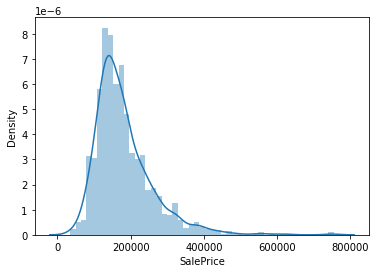

In [5]:
#histograma
sns.distplot(df_train["SalePrice"])

La construccion de una matris de correlaciones nos puede ayudar a dar un primer vistaso de las variables y sus relaciones.

In [6]:
corr = df_train.corr()
corr.style.background_gradient()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,-0.005968,-0.007940,-0.015415,0.010496,0.005590,-0.044230,0.008273,0.002289,-0.020155,0.005587,0.006784,0.037719,0.002951,0.027239,-0.019772,0.000072,0.016570,0.017634,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,0.085072,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,0.132644,0.392075,0.457181,0.080177,0.038469,0.402797,0.100949,-0.007234,0.198769,0.053532,0.263170,-0.006069,0.352096,0.266639,0.070250,0.285691,0.344997,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,-0.024947,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.547766,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.324297,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.825667,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.642277,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,0.114442,0.363936,0.344501,0.174561,-0.069071,0.390857,0.085310,0.026673,0.276833,0.201444,0.102821,-0.037610,0.280682,0.249070,0.252691,0.364204,0.373066,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.153484,0.224054,0.296970,0.204306,0.111761,-0.102303,0.026451

Podemos obtener las variables que tienen un nivel de correlacion mas alto con la variable SalePrice de la sig forma:

In [7]:
corr[corr["SalePrice"] > 0.5].index

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea',
       'SalePrice'],
      dtype='object')

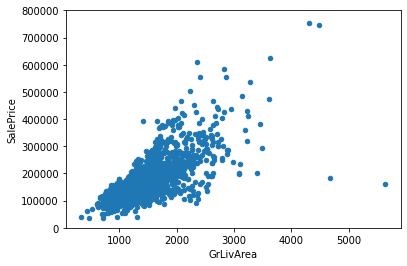

In [8]:
# relacion lineal
data = pd.concat([df_train["SalePrice"], df_train["GrLivArea"]], axis=1)

data.plot.scatter(x="GrLivArea", y="SalePrice", ylim=(0,800000))

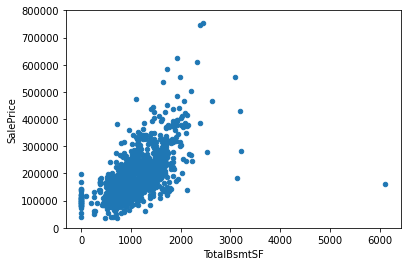

In [9]:
# relacion lineal (exponencial?)
data = pd.concat([df_train["SalePrice"], df_train["TotalBsmtSF"]], axis=1)

data.plot.scatter(x="TotalBsmtSF", y="SalePrice", ylim=(0,800000))

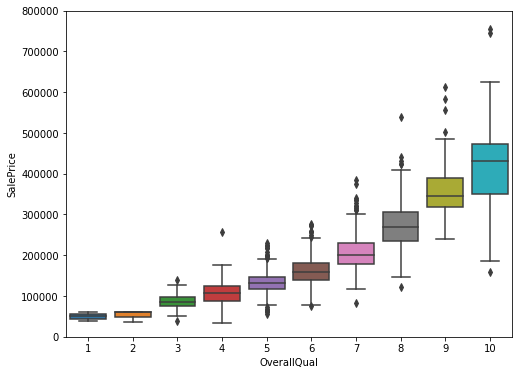

In [10]:
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

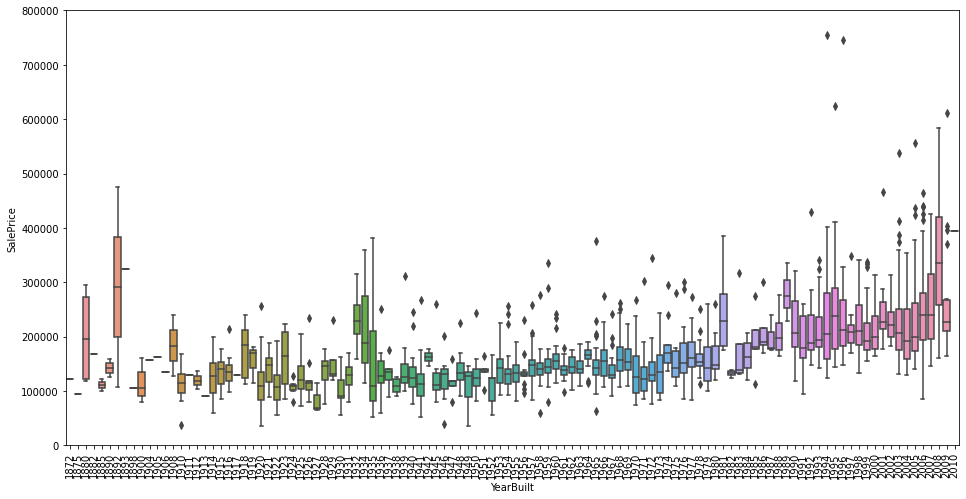

In [11]:
var = 'YearBuilt'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

Vemos que sin duda hay cierta relacion entre algunas de las variables obtenidas de la matris de correlaciones con respecto a la columna SalePrice

Podemos concluir que:

'GrLivArea' y 'TotalBsmtSF' parecen estar linealmente relacionados con 'SalePrice'. Ambas relaciones son positivas, lo que significa que a medida que aumenta una variable, la otra también aumenta. En el caso de 'TotalBsmtSF', podemos ver que la pendiente de la relación lineal es particularmente alta.
'OverallQual' y 'YearBuilt' también parecen estar relacionados con 'SalePrice'. La relación parece ser más fuerte en el caso de 'OverallQual', donde el diagrama de caja muestra cómo aumentan los precios de venta con la calidad general.

<br/>
OBS:

Por otro lado podemos ver que ciertas variables podrian ser redundantes por ejm:

  * Las varibles `GarageCars` y `GarageArea` que hacen referencia a lo mismo (dimensiones del garage)
  * Por otro lado `TotRmsAbvGrd` y `GrLivArea` tmb parecieran referirse a lo mismo.
  * Y por ultimo las variables `TotalBsmtSF` y `1stFloor`.

Ahora vamos a hacer un analisis mas fino de las variables que resultan de interes.

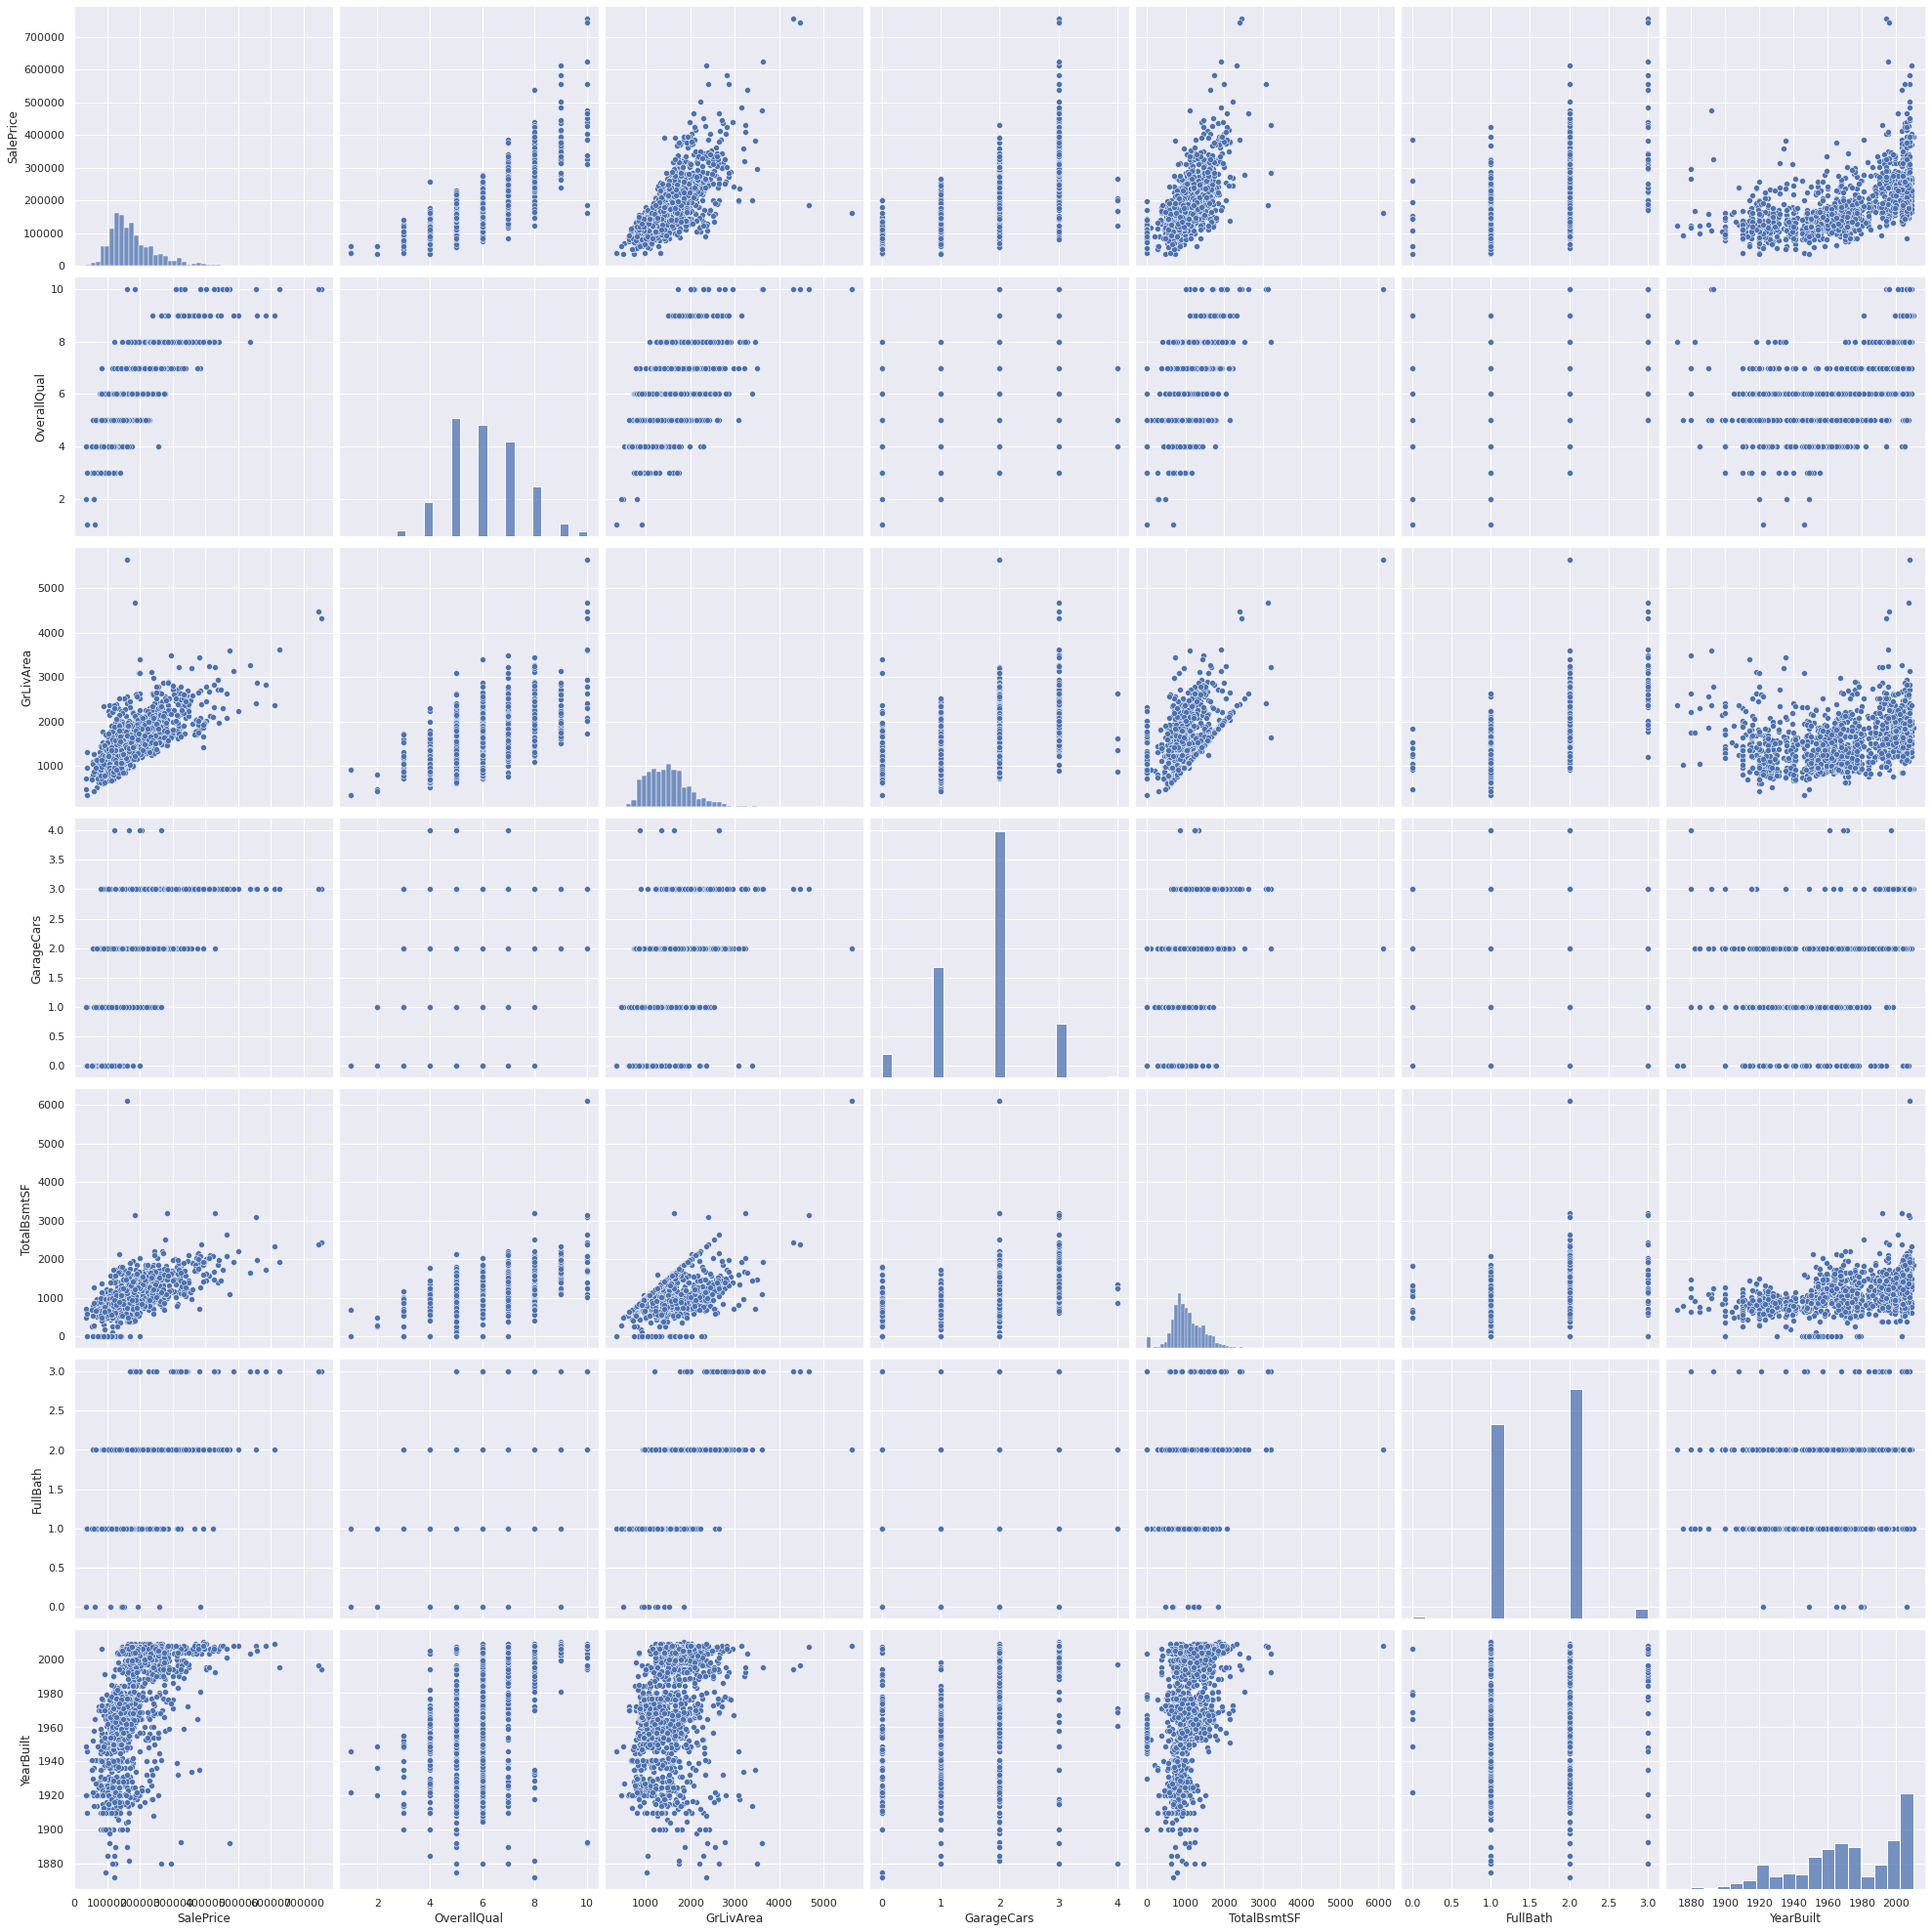

In [12]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.set()
sns.pairplot(df_train[cols], height = 4)
plt.show()

### Tratando los valores nulos
(train data)

Veamos en que columnas se encuentran los valores nulos y cuantos de estos tenemos

In [15]:
col_w_missing_value = [col for col in df_train.columns if df_train[col].isnull().any()]

missing_values_tot = df_train[col_w_missing_value].isnull().sum().sort_values(ascending=False)
missing_values_perc = (df_train[col_w_missing_value].isnull().sum()/df_train[col_w_missing_value].isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([missing_values_tot, missing_values_perc], axis=1, keys=["Total", "Percent"])

missing_data

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479


Siempre hay que tener en cuenta cuales son las variables de interes en nuestro caso eran: 

* SalePrice 
* OverallQual 
* GrLivArea 
* GarageCars 
* TotalBsmtSF
* FullBath 
* YearBuilt


Ahora para los valores nulos vamos a aplicar la regla del 15%, si vemos que tenemos mas de un 15% de datos nulos en una columna entonces vamos optar por dropear dicha columna.

Ahora con respecto a las variables tipo Garage y Bsmt, al no ser relevantes para nuestro analisis optamos por dropear las columnas.



In [16]:
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,706,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,2,548,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,TA,TA,CBlock,978,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,2,460,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,486,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,2,608,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,TA,TA,BrkTil,216,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,3,642,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,655,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,3,836,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,TA,TA,PConc,0,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,2,460,Y,0,40,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,TA,TA,CBlock,790,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,2,500,Y,349,0,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,Ex,Gd,Stone,275,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,1,252,Y,0,60,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,TA,TA,CBlock,49,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,1,240,Y,366,0,112,0,0,0,0,4,2010,WD,Normal,142125


### Out liars

Ahora vamos a tratar algunos de los out liars:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


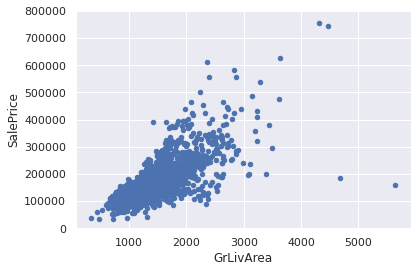

In [17]:
# GrLivArea
data = pd.concat([df_train['SalePrice'], df_train['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000))

In [18]:
# buscamos los 4 valores mas alejados
id_outliars = df_train.sort_values(by=["GrLivArea"], ascending=False).head(4)["Id"]

id_outliars = np.array(id_outliars)

df_train = df_train.drop(df_train[df_train['Id'] == id_outliars[0]].index)
df_train = df_train.drop(df_train[df_train['Id'] == id_outliars[1]].index)
df_train = df_train.drop(df_train[df_train['Id'] == id_outliars[2]].index)
df_train = df_train.drop(df_train[df_train['Id'] == id_outliars[3]].index)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


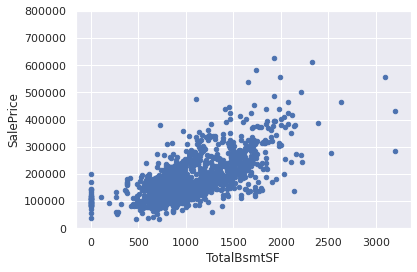

In [19]:
# TotalBsmtSF
data = pd.concat([df_train['SalePrice'], df_train["TotalBsmtSF"]], axis=1)
data.plot.scatter(x="TotalBsmtSF", y='SalePrice', ylim=(0,800000));

In [20]:
# buscamos los 3 valores mas alejados
id_outliars_bsm = df_train.sort_values(by=["TotalBsmtSF"], ascending=False).head(3)["Id"]
id_outliars_bsm = np.array(id_outliars_bsm)

df_train = df_train.drop(df_train[df_train['Id'] == id_outliars_bsm[0]].index)
df_train = df_train.drop(df_train[df_train['Id'] == id_outliars_bsm[1]].index)
df_train = df_train.drop(df_train[df_train['Id'] == id_outliars_bsm[2]].index)

In [21]:
#df_sample['SalePrice'] = np.log(df_sample['SalePrice'])
df_test['GrLivArea'] = np.log(df_test['GrLivArea'])
df_test['HasBsmt'] = pd.Series(len(df_test['TotalBsmtSF']), index=df_test.index)
df_test['HasBsmt'] = 0 
df_test.loc[df_test['TotalBsmtSF']>0,'HasBsmt'] = 1

#transform data
df_test.loc[df_test['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_test['TotalBsmtSF'])

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Normalizacion de variables

SalePrice:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


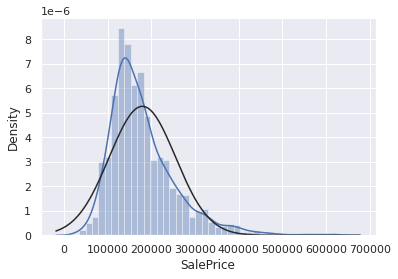

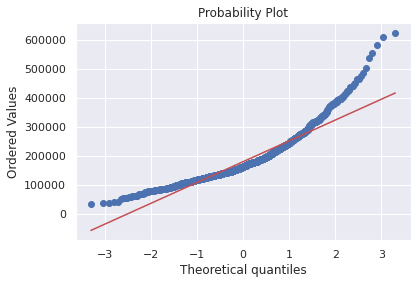

In [22]:
# histograma y distribucion normal
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

In [23]:
# aplicamos la transformacion logaritmica
df_train['SalePrice'] = np.log(df_train['SalePrice'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


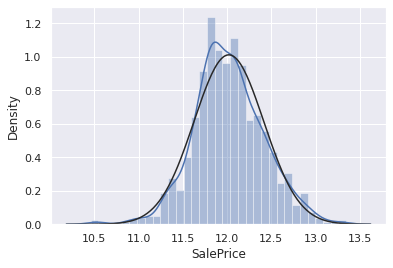

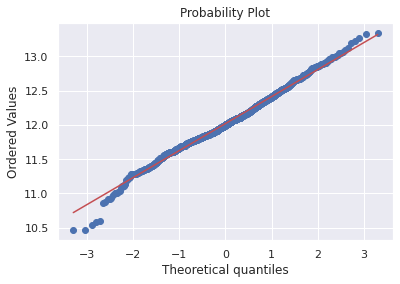

In [24]:
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

GrLivArea:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


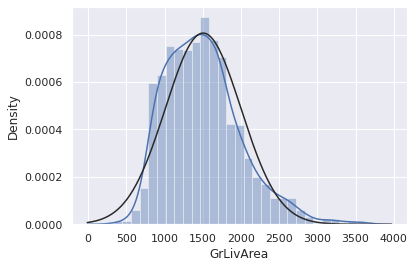

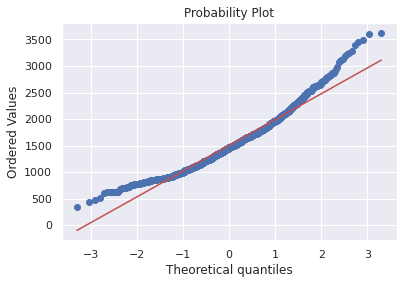

In [25]:
# histograma y distribucion normal
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


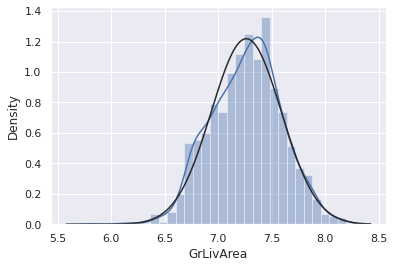

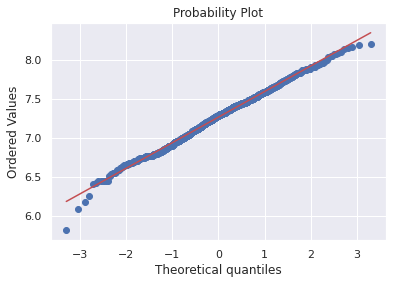

In [26]:
# aplicamos la transformacion logaritmica
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])

sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

TotalBsmtSF:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


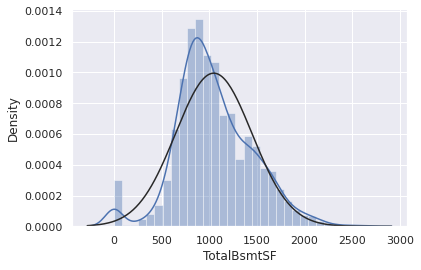

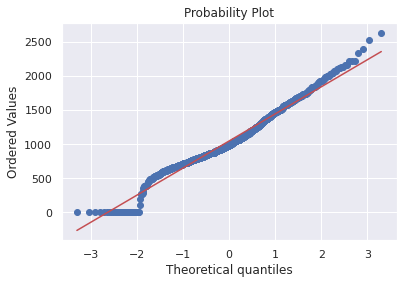

In [27]:
# histograma y distribucion normal
sns.distplot(df_train['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['TotalBsmtSF'], plot=plt)

Aqui nos enfrentamos a una situacion un tanto diferente, ya que hay muchas casas que no tienen zotano, por lo que en esta variable guardan un 0 y como bien sabemos log(0) no esta definido...Por lo que hay que buscar otra estrategia.

Vamos a crear una variable binaria, la cual nos dira si dicha casa tiene o no zotano y luego haremos la transformacion a todas aquellas filas que no presenten un 0 en esta nueva columna.

In [28]:
df_train['HasBsmt'] = pd.Series(len(df_train['TotalBsmtSF']), index=df_train.index)
df_train['HasBsmt'] = 0 
df_train.loc[df_train['TotalBsmtSF']>0,'HasBsmt'] = 1

#transform data
df_train.loc[df_train['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_train['TotalBsmtSF'])

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


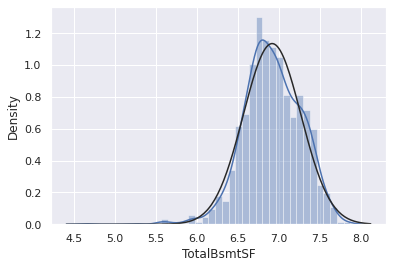

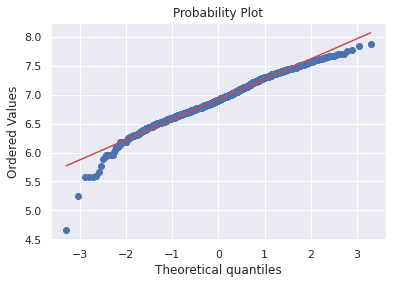

In [29]:
#histogram and normal probability plot
sns.distplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)